# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
The goal of this project is to write software pipeline to identify the lane boundaries in a video from a front-facing camera. 

The project include three steps:
* Camera calibration: compute the camera matrix and distortion coefficients. 
* Develop a pipeline for lane finding in single images.
* Develop a pipeline for lane finding in video.

## Camera Calibration

Cameras use lenses which can make the light to bend at the edges of the lenses, which cause distortion. This can make the object to appear more or less curved than what actually are (radial distortion) or objects might appear further away or closer than what they actually are (tangential distortion). This should be corrected in order to accurately determine the position and distance of the objects.

So, the first step is to obtain the 5 coefficients (k1, k2, p1, p2 and k3) which reflect the radial and tangential distortion in an image, and that would allow us to undistort the images of the camera.

To calculate the 5 coefficients, I will use pictures of a known shapes (chessboard) and correct for distortion errors.

## Import packages

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [35]:
# Define a helper function in order to calibrate a camera
# It receives as a parameter the number of inside corner points of the chessboard (nx, ny) and the set of images for calibration
def calibrate_camera(nx, ny, images):
    # store the 3d points in real world space
    objpoints = []

    # store the 2d points in image plane
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    size = 0 # size of the image (width and height in pixel)

    for image in images:
        img = cv2.imread(image)

        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if (size == 0): # we still have not calculated the size
            size = gray.shape[::-1]

        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            # Append the img points and obj points
            imgpoints.append(corners)
            objpoints.append(objp)

    # Now that we have the set of image points and corresponding obj points, we can calibrate the camera. The camera
    # calibration returns: ret, mtx (camera matrix to transform 3d object points to 2d image points), dist (distorted coefficients), rvecs and tvecs (rotation and translation vector which position camera in the world)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None, None)
    return ret, mtx, dist, rvecs, tvecs


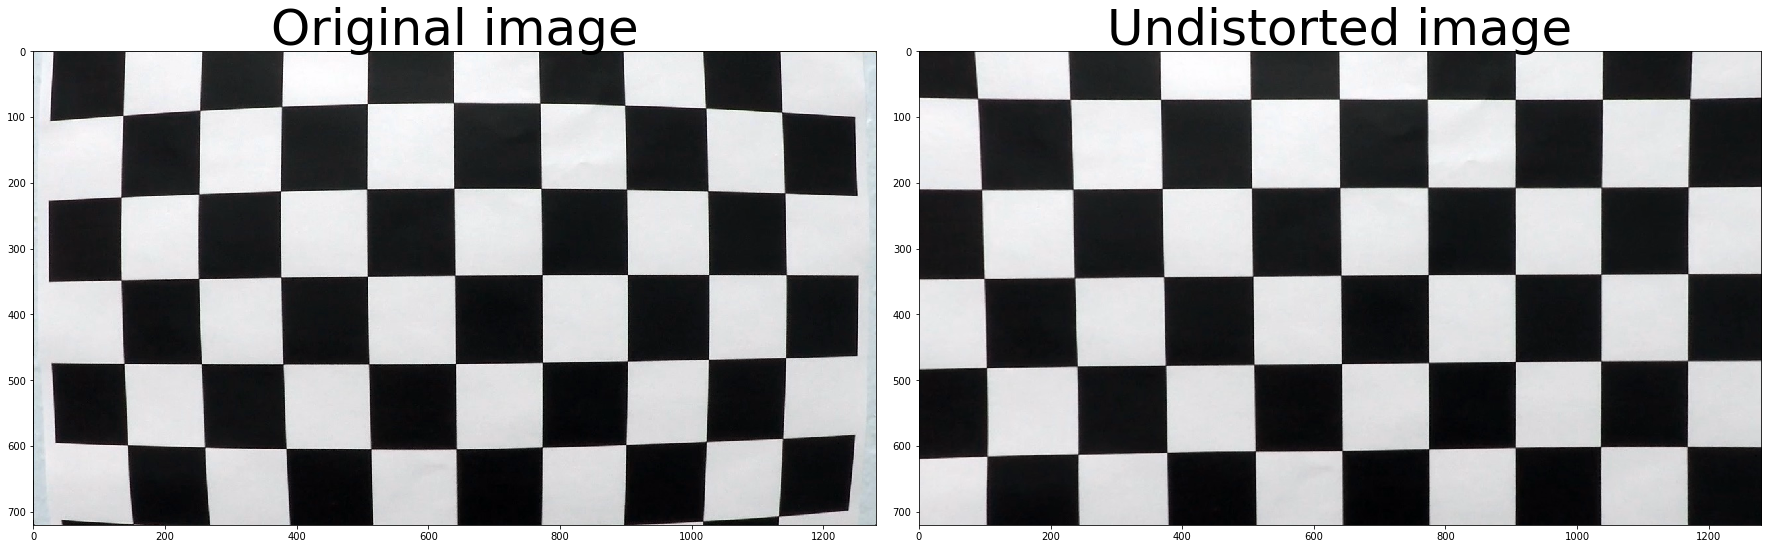

In [36]:
# number of object points (number of inside corners of the chessboard in x and y direction)
nx = 9
ny = 6
ret, mtx, dist, rvecs, tvecs = calibrate_camera(nx, ny, glob.glob("camera_cal/calibration*.jpg"))

# Now we have the distortion coefficients
# Let's undistort an image provided
img = cv2.imread("camera_cal/calibration1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Let's show the original image an the undistorted image to demonstrate that the calibration is correct
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline (test images)

The aim of this section is to provide a pipeline of a test image and perform the following steps:
* Undistort the image (distortion correction).
* Create a binary image that contains a likely lane pixes (use color transforms, gradients).
* Perform a perspective transform: rectify the image to a "birds-eye view".
* Identify lane line pixels in the rectified binary images and fit the positions with a polynomial.
* Calculate the radius of curvature of the lane and the position of the vehicle with respect to center: take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located (deviation of the midpoint of the lane from the center of the image). 
* Provide an example image of the result plotted back down onto the roadsuch taht the lane area is identified clearly: the fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. Display image with lanes, info of the curvature and position from the center.

### Helper functions

In [52]:
def undistort(img, mtx, dist):
    """Returns an undistorted image (img) given the camera matrix (mtx) and the distortion coefficients (dist)"""
    return cv2.undistort(img, mtx, dist, None, mtx)

def warp(img, src):
    """
    Perform a perspective transform: rectify the image to a "bird-eyeview"
    We assume that img is already a corrected (undistorted image)
    It is given as a parameters the src points """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_size = (gray.shape[1], gray.shape[0])
    
    offset = 100 #offset for the dst points
    
    # Define the dst points
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                     [img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
    
    # Obtain the matrix that allows us to transform from the src points to the dst points
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Obtain the warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

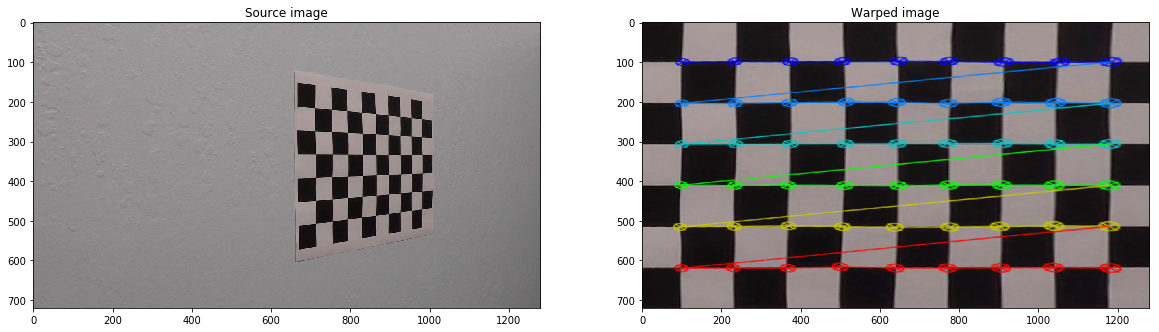

In [54]:
# Test the perspective transfom
img = cv2.imread('camera_cal/calibration8.jpg')
img_corrected = undistort(img, mtx, dist)
gray = cv2.cvtColor(img_corrected, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    cv2.drawChessboardCorners(img_corrected, (nx,ny), corners, ret)
    # src points
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    warped = warp(img_corrected, src)

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_title('Source image')
    ax1.imshow(img)
    ax2.set_title('Warped image')
    ax2.imshow(warped)

## Pipeline (video)

Run the above pipeline in a video. Lines, curvature and vehicle position are identified at every frame. Usse information from prior detection to inform the search for the position of the lines in subsequent frames of the video.

Smoothing for lane detection (low pass filter?). Add each new detection to a weighted mean of the position of the liens to avoid jitter.

## Discussion

Discuss problems, issues during implementation. When the pipeline might fail. What can be done to make it more robust.

## Read in an Image

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/solidWhiteRight.jpg'

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calculate_lines(lines):
    """
    From the lines of the hough transform, calculate the interpolated position of the lines
    """
    # seperate the x coordinates and y coordinates of the right and left lane segments
    rightX = []
    rightY = []
    leftX = []
    leftY = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            # let's seperate the right and left based on the slope value
            slope = (y2-y1) / (x2-x1)
            
            # We discard lines with slope close to zero because they can introduce noise
            if (slope < -0.3):
                rightX.append(x1)
                rightX.append(x2)
                rightY.append(y1)
                rightY.append(y2)
            else:
                if (slope > 0.3):
                    leftX.append(x1)
                    leftX.append(x2)
                    leftY.append(y1)
                    leftY.append(y2)    
                
    coefR = np.polyfit(rightX, rightY, 1)
    coefL = np.polyfit(leftX, leftY, 1)
    
    # These are the values of the region interest for the y coordinate (they are fix values)
    Ymax = 539
    Ymin = 320
    
    # Lets calcualte the corresponding x coordinate for the right and left line
    Xmax_right = int((Ymax - coefR[1])/coefR[0])
    Xmin_right = int((Ymin - coefR[1])/coefR[0])
    Xmax_left = int((Ymax - coefL[1])/coefL[0])
    Xmin_left = int((Ymin - coefL[1])/coefL[0])
    
    # return the coordinates of the two lines (right and left)
    return [Ymax, Ymin, Xmax_right, Xmin_right, Xmax_left, Xmin_left] 

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    lines_processed = calculate_lines(lines)
    
    # lines processed return an array of values with this format:
    # [Ymax, Ymin, Xmax_right, Xmin_right, Xmax_left, Xmin_left]
    
    Ymax = lines_processed[0]
    Ymin = lines_processed[1]
    Xmax_right = lines_processed[2]
    Xmin_right = lines_processed[3]
    Xmax_left = lines_processed[4]
    Xmin_left = lines_processed[5]
    
    cv2.line(img, (Xmin_left, Ymin), (Xmax_left, Ymax), color, thickness)
    cv2.line(img, (Xmin_right, Ymin), (Xmax_right, Ymax), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

import matplotlib.image as mpimg

testImages = os.listdir("test_images/")

for imageName in testImages:
    imageOriginal = mpimg.imread('test_images/'+imageName)
    image = np.copy(imageOriginal) # We will process the image and keep imageOriginal as intact

    # Lets first obtain a mask based on color. We need to take into account that we need to get both yellow and white
    # We remove the blue chanel, to detect both white and yellow
    red_threshold = 200
    green_threshold = 200

    rgb_threshold = [red_threshold, green_threshold]

    color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                        (image[:,:,1] < rgb_threshold[1]) 

    image[color_thresholds] = [0, 0, 0]

    # We convert the image to grayscale
    image = grayscale(image)

    # We then apply some gaussian filtering to smooth the image and reduce some artifacts
    kernel_size_smooth = 5
    image = gaussian_blur(image, kernel_size_smooth)

    # We apply Canny edge detection in order te detect edges
    # I selected high threshold in order to detect what apparently can be visually "one line" for each side of the 
    # road. The high threshold is the most important as determines which one definetly selected
    low_threshold = 50
    high_threshold = 150
    edges = canny(image, low_threshold, high_threshold)

    # We then apply some filtering through region. I do this after canny, as if I do before, the canny edge detection 
    # detect the boundaries of the polygon of of the region
    vertices = np.array( [[[150,539],[900,539],[520,320], [450,320]]] )
    edges = region_of_interest(edges, vertices)

    # Now we apply a hough transform in order to find the lines
    rho = 1
    theta = np.pi/180
    threshold = 10
    min_line_len = 3
    max_line_gap = 10
    lines = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Lets compute the final image
    resultImg = weighted_img(lines, imageOriginal)

    cv2.imwrite('test_images_output/'+imageName, cv2.cvtColor(resultImg, cv2.COLOR_RGB2BGR))

    plt.imshow(resultImg)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

In [ ]:
Xmax_right_history = deque(maxlen=10)
Xmin_right_history = deque(maxlen=10)
Xmax_left_history = deque(maxlen=10)
Xmin_left_history = deque(maxlen=10)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # Lets first obtain a mask based on color. We need to take into account that we need to get both yellow and white
    # We remove the blue chanel, to detect both white and yellow
    
    imageOriginal = np.copy(image)
    
    red_threshold = 200
    green_threshold = 200

    rgb_threshold = [red_threshold, green_threshold]

    color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                        (image[:,:,1] < rgb_threshold[1]) 

    image[color_thresholds] = [0, 0, 0]

    # We convert the image to grayscale
    image = grayscale(image)

    # We then apply some gaussian filtering to smooth the image and reduce some artifacts
    kernel_size_smooth = 5
    image = gaussian_blur(image, kernel_size_smooth)

    # We apply Canny edge detection in order te detect edges
    # I selected high threshold in order to detect what apparently can be visually "one line" for each side of the 
    # road. The high threshold is the most important as determines which one definetly selected
    low_threshold = 50
    high_threshold = 150
    edges = canny(image, low_threshold, high_threshold)

    # We then apply some filtering through region. I do this after canny, as if I do before, the canny edge detection 
    # detect the boundaries of the polygon of of the region
    vertices = np.array( [[[150,539],[900,539],[520,320], [450,320]]] )
    edges = region_of_interest(edges, vertices)

    # Now we apply a hough transform in order to find the lines
    rho = 1
    theta = np.pi/180
    threshold = 10
    min_line_len = 3
    max_line_gap = 10
    
    # We get the lines of the hough transform
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap) 
    
    # We process the lines
    lines_processed = calculate_lines(lines)
    
    # lines_processed has a form like: [Ymax, Ymin, Xmax_right, Xmin_right, Xmax_left, Xmin_left]
    # We draw the lines into an image (line_img)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    Ymax = lines_processed[0]
    Ymin = lines_processed[1]
    
    Xmax_right_history.append(lines_processed[2])
    Xmin_right_history.append(lines_processed[3])
    Xmax_left_history.append(lines_processed[4])
    Xmin_left_history.append(lines_processed[5])

    color=[255, 0, 0]
    thickness=5
    
    cv2.line(line_img, (int(np.average(Xmin_left_history)), Ymin), (int(np.average(Xmax_left_history)), Ymax), color, thickness)
    cv2.line(line_img, (int(np.average(Xmin_right_history)), Ymin), (int(np.average(Xmax_right_history)), Ymax), color, thickness)

    # Lets compute the final image
    resultImg = weighted_img(line_img, imageOriginal)

    return resultImg

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))